In [98]:
import os
import sys
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')
pplt.rc.update({'figure.dpi':100,'reso':'xx-hi'})

In [99]:
with open('../scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['experiments']
LATRANGE   = CONFIGS['domain']['latrange']
LONRANGE   = CONFIGS['domain']['lonrange']
SPLIT      = 'valid'   
PRTHRESH   = 0.03

In [100]:
def get_r2(ytrue,ypred,dims=None):
    dims  = list(ytrue.dims) if dims is None else dims
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [117]:
def plot_r2_bars(results):
    names,r2means,colors = [],[],[]
    seeds  = any(('seed' in get_r2(ytrue,ypred,dims=None).dims and get_r2(ytrue,ypred,dims=None).sizes.get('seed',0)>1) for _,ytrue,ypred in results)
    r2stds = [] if seeds else None
    for name,ytrue,ypred in results:
        r2 = get_r2(ytrue,ypred,dims=None)
        seed = 'seed' in r2.dims and r2.sizes.get('seed',0)>1
        r2mean,r2std = (r2.mean('seed'),r2.std('seed')) if seed else (r2,None)
        names.append(name)
        r2means.append(float(r2mean))
        if seeds:
            r2stds.append(float(r2std) if r2std is not None else 0.0)
        colors.append('gray6' if 'pod' in name else 'blue3' if '75' in name else 'blue6' if '50' in name else'yellow6' if 'cosh' in name else 'red6')
    order  = np.argsort(r2means)
    names  = [names[i] for i in order]
    r2means= [r2means[i] for i in order]
    colors = [colors[i] for i in order]
    if seeds:
        r2stds = [r2stds[i] for i in order]
    fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=6,refheight=3)
    ax.format(suptitle='R$^2$ by Model',grid=False,xminorticks='none')
    bars = ax.barh(names,r2means,xerr=(r2stds if seeds else None),color=colors,capsize=(3 if seeds else 0))
    for bar,r2mean in zip(bars,r2means):
        ax.text(bar.get_width()-0.015,bar.get_y()+bar.get_height()/2,f'{r2mean:.3f}',va='center',ha='left')
    pplt.show()

def plot_mse_by_bin(results,minsample=5):
    binedges  = [0,0.03,0.1,1,5,10,20,np.inf]
    binlabels = ['0–0.03','0.03–0.1','0.1–1','1–5','5–10','10–20','>20']
    nbins     = len(binlabels)
    nmodels   = len(results)
    barwidth  = 0.7/nmodels
    fig,ax    = pplt.subplots(nrows=1,ncols=1,refwidth=6,refheight=3)
    ax.format(suptitle='MSE by Rain Bin',grid=False,ylabel='MSE',yscale='log',yformatter='log',
              xlabel='Observed Precipitation (mm/hr)',xticks=np.arange(nbins),xticklabels=binlabels,xminorticks='none')
    for mi,(name,ytrue,ypred) in enumerate(results):
        color    = 'gray6' if 'pod' in name else 'blue3' if '75' in name else 'blue6' if '50' in name else'yellow6' if 'cosh' in name else 'red6'
        hasseed  = 'seed' in ypred.dims and ypred.sizes.get('seed',0)>1
        ypredmean = ypred.mean('seed') if hasseed else ypred
        truevals  = ytrue.values.ravel()
        predvals  = ypredmean.values.ravel()
        mask      = np.isfinite(truevals)&np.isfinite(predvals)
        truevals, predvals = truevals[mask],predvals[mask]
        msevals = np.full(nbins,np.nan)
        msestd  = np.zeros(nbins)
        for i in range(nbins):
            lo,hi = binedges[i],binedges[i+1]
            idx   = (truevals>=lo)&(truevals<hi)
            if idx.sum() >= minsample:
                msevals[i] = np.mean((truevals[idx]-predvals[idx])**2)
        if hasseed:
            mseseeds = []
            for s in range(ypred.sizes['seed']):
                pv = ypred.isel(seed=s).values.ravel()[mask]
                ms = np.full(nbins,np.nan)
                for i in range(nbins):
                    lo,hi = binedges[i],binedges[i+1]
                    idx   = (truevals>=lo)&(truevals<hi)
                    if idx.sum()>=minsample:
                        ms[i] = np.mean((truevals[idx]-pv[idx])**2)
                mseseeds.append(ms)
            msestd = np.nanstd(mseseeds,axis=0)
        xpos = np.arange(nbins)+(mi-(nmodels-1)/2)*barwidth
        ax.bar(xpos,msevals,width=barwidth,color=color,label=name,yerr=(msestd if hasseed else None),capsize=3)
    ax.legend(loc='ul',ncols=1)
    pplt.show()
    
def plot_density_panels(results,globalmin=1e-9,globalmax=globalmax,nbins=60):
    n=len(results); ncols=int(np.ceil(np.sqrt(n))); nrows=int(np.ceil(n/ncols))
    binedges = np.logspace(np.log10(globalmin),np.log10(globalmax),nbins+1)
    arr = np.arange(1,nrows*ncols+1).reshape(nrows,ncols); arr[arr>n]=0
    fig,axs = pplt.subplots(array=arr,refwidth=2,share=True)
    axs.format(suptitle='Observed vs. Predicted Precipitation Density',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')
    axs = np.atleast_1d(axs).ravel()
    for ax,(name,ytrue,ypred) in zip(axs,results):
        r2 = get_r2(ytrue,ypred,dims=None)
        seed = 'seed' in r2.dims and r2.sizes.get('seed',0)>1
        r2mean,r2std = (r2.mean('seed'),r2.std('seed')) if seed else (r2,None)
        ypredmean = ypred.mean('seed') if seed else ypred
        ytrueflat  = ytrue.values.ravel()
        ypredflat  = ypredmean.values.ravel()
        mask = (np.isfinite(ytrueflat)&np.isfinite(ypredflat)&(ytrueflat>0)&(ypredflat>0))
        hist,_,_ = np.histogram2d(ytrueflat[mask],ypredflat[mask],bins=[binedges,binedges])
        hist = np.ma.masked_where(hist==0,hist)
        im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',norm='log',extend='both')
        ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
        text = f'R$^2$ = {float(r2mean):.3f}'+(f' ± {float(r2std):.3f}' if seed else '')
        ax.text(0.05,0.95,text,transform=ax.transAxes,va='top',ha='left')
        ax.format(title=name,
                  xscale='log',xformatter='log',xlim=(globalmin,globalmax),xticks=[globalmin,1e0,globalmax],xminorticks='none',
                  yscale='log',yformatter='log',ylim=(globalmin,globalmax),yticks=[globalmin,1e0,globalmax],yminorticks='none')
    fig.colorbar(im,loc='r',label='Counts')
    pplt.show()

def plot_rain_distribution_panels(results,mode='frequency',spacing=0.07,globalmax=globalmax,density=False,prthresh=PRTHRESH):
    n=len(results); ncols=int(np.ceil(np.sqrt(n))); nrows=int(np.ceil(n/ncols))
    r = 1.0+spacing
    kmax    = int(np.ceil(np.log(globalmax/prthresh)/np.log(r)))
    bincenters = prthresh*(r**np.arange(kmax+1))
    binedges   = np.concatenate([bincenters/np.sqrt(r),[bincenters[-1]*np.sqrt(r)]])
    arr = np.arange(1,nrows*ncols+1).reshape(nrows,ncols); arr[arr>n]=0
    fig,axs = pplt.subplots(array=arr,refwidth=2,share=True)
    ylabel = ('Density' if density else 'Count') if mode=='frequency' else 'Amount (mm/hr)'
    axs.format(suptitle='Observed vs. Predicted Precipitation Distributions',grid=False,
               xlabel='Precipitaiton Rate (mm/hr)',ylabel=ylabel)
    axs = np.atleast_1d(axs).ravel()
    for ax,(name,ytrue,ypred) in zip(axs,results):
        r2 = get_r2(ytrue,ypred,dims=None)
        seed = 'seed' in r2.dims and r2.sizes.get('seed',0)>1
        r2mean,r2std = (r2.mean('seed'),r2.std('seed')) if seed else (r2,None)
        ypredmean = ypred.mean('seed') if seed else ypred
        ytrueflat = ytrue.values.ravel()
        ypredflat = ypredmean.values.ravel()
        truemask0 = np.isfinite(ytrueflat)&(ytrueflat>=0)
        predmask0 = np.isfinite(ypredflat)&(ypredflat>=0)
        truemask  = truemask0&(ytrueflat>prthresh)
        predmask  = predmask0&(ypredflat>prthresh)
        drytrue = 1.0-(truemask.sum()/max(truemask0.sum(),1))
        drypred = 1.0-(predmask.sum()/max(predmask0.sum(),1))
        if mode=='amount':
            histtrue,_ = np.histogram(ytrueflat[truemask],bins=binedges,weights=ytrueflat[truemask])
            histpred,_ = np.histogram(ypredflat[predmask],bins=binedges,weights=ypredflat[predmask])
        else:
            histtrue,_ = np.histogram(ytrueflat[truemask],bins=binedges,density=density)
            histpred,_ = np.histogram(ypredflat[predmask],bins=binedges,density=density)
        ax.step(bincenters,histtrue,where='mid',color='k',label='Observed')
        ax.step(bincenters,histpred,where='mid',color='red6',label='Predicted')
        text = f'R$^2$ = {float(r2mean):.3f}'+(f' ± {float(r2std):.3f}' if seed else '')
        ax.text(0.05,0.95,text,transform=ax.transAxes,va='top',ha='left')
        ax.text(0.05,0.85,f'{drytrue:.0%} vs.         Dry',transform=ax.transAxes,va='top',ha='left')
        ax.text(0.28,0.85,f'{drypred:.0%}',transform=ax.transAxes,va='top',ha='left',color='red6')
        ax.format(title=name,xscale='log',xformatter='log',xlim=(prthresh,globalmax),xminorticks='none',yminorticks='none')
    axs[0].legend(loc='ur',ncols=1,frame=False)
    pplt.show()
    
def plot_bias_maps(results):
    names,biases = [],[]
    for name,ytrue,ypred in results:
        ypredmean = ypred.mean('seed') if ('seed' in ypred.dims and ypred.sizes.get('seed',0)>1) else ypred
        bias = (ypredmean-ytrue).mean('time').squeeze()
        names.append(name)
        biases.append(bias)
    n=len(biases); ncols=int(np.ceil(np.sqrt(n))); nrows=int(np.ceil(n/ncols))
    arr = np.arange(1,nrows*ncols+1).reshape(nrows,ncols); arr[arr>n]=0
    fig,axs = pplt.subplots(array=arr,proj='cyl',refwidth=2,share=False)
    axs.format(suptitle='Time-Mean Precipitation Bias',grid=False,coast=True,
               latlim=LATRANGE,latlines=5,lonlim=LONRANGE,lonlines=5)
    axs  = np.atleast_1d(axs).ravel()
    vmax = max(float(abs(b).max()) for b in biases)
    for ax,name,bias in zip(axs,names,biases):
        im = ax.pcolormesh(bias.lon,bias.lat,bias,cmap='ColdHot',vmin=-vmax,vmax=vmax,levels=21,extend='both')
        ax.format(title=name)
    fig.colorbar(im,loc='b',label='Precipitation Bias (mm/hr)')
    pplt.show()

def plot_r2_maps(results):
    n=len(results); ncols=int(np.ceil(np.sqrt(n))); nrows=int(np.ceil(n/ncols))
    arr = np.arange(1,nrows*ncols+1).reshape(nrows,ncols); arr[arr>n]=0
    fig,axs = pplt.subplots(array=arr,refwidth=2,proj='cyl',share=False)
    axs.format(suptitle='Time-Mean R$^2$',grid=False,coast=True,latlim=LATRANGE,lonlim=LONRANGE)
    axs = np.atleast_1d(axs).ravel()
    for ax,(name,ytrue,ypred) in zip(axs,results):
        r2 = get_r2(ytrue,ypred,dims=['time'])
        seed = 'seed' in r2.dims and r2.sizes.get('seed',0)>1
        r2mean,_ = ((r2.mean('seed').squeeze(),r2.std('seed')) if seed else (r2.squeeze(),None))
        im = ax.pcolormesh(r2mean.lon,r2mean.lat,r2mean,cmap='ColdHot',cmap_kw={'left':0.5},vmin=0,vmax=0.4,levels=9,extend='both')
        ax.format(title=name)
    fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
    pplt.show()
    
def plot_confusion_matrix(results,prthresh=PRTHRESH):
    n=len(results); ncols=int(np.ceil(np.sqrt(n))); nrows=int(np.ceil(n/ncols))
    arr = np.arange(1,nrows*ncols+1).reshape(nrows,ncols); arr[arr>n]=0
    fig,axs = pplt.subplots(array=arr,refwidth=2,share=True)
    axs     = np.atleast_1d(axs).ravel()
    labels  = [('TN',0,0,0.5,0.5),('FP',0,1,1.5,0.5),('FN',1,0,0.5,1.5),('TP',1,1,1.5,1.5)]
    for ax,(name,ytrue,ypred) in zip(axs,results):
        ytrueabove,ypredabove = ytrue>prthresh,ypred>prthresh
        dims = list(ytrue.dims)
        tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True)
        tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
        fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
        fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True)
        total = tp+fp+fn+tn
        seed  = hasattr(total,'dims') and ('seed' in total.dims and total.sizes.get('seed',0)>1)
        if seed:
            pct = [100.0*x/total for x in (tn,fp,fn,tp)]
            mean,std   = [p.mean('seed') for p in pct],[p.std('seed') for p in pct]
            matrixmean = np.array([[mean[0],mean[1]],[mean[2],mean[3]]],dtype=float)
            matrixstd  = np.array([[std[0],std[1]],[std[2],std[3]]],dtype=float)
        else:
            matrixmean = 100.0*np.array([[float(tn),float(fp)],[float(fn),float(tp)]],dtype=float)/float(total)
            matrixstd  = np.zeros((2,2))
        im = ax.pcolormesh([0,1,2],[0,1,2],matrixmean,cmap='Blues',vmin=0,vmax=100,levels=111)
        for label,i,j,x,y in labels:
            text = f'{label}\n{matrixmean[i,j]:.1f}{" ± "+f"{matrixstd[i,j]:.1f}%" if seed else "%"}'
            ax.text(x,y,text,ha='center',va='center')
        ax.format(suptitle=f'Confusion Matrix (Threshold = {prthresh} mm/hr)',title=name,
                  xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
                  ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
    fig.colorbar(im,loc='r',ticks=10,label='Percent of Samples')
    pplt.show()

In [109]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = []
for group in ['pod','nn']:
    for name,_ in MODELS[group]['runs'].items():
        filepath  = os.path.join(PREDSDIR,f'{name}_{SPLIT}_predictions.nc')
        if os.path.exists(filepath):
            with xr.open_dataset(filepath) as ds:
                predpr  = ds.pr.load()
            ytrue,ypred = xr.align(truepr,predpr,join='inner')
            results.append((name,ytrue,ypred))

print(f'Found {len(results)} models with predictions!')

Found 5 models with predictions!


In [110]:
allvals = []
for _, ytrue, ypred in results:
    yt = ytrue.values.ravel()
    yp = ypred.values.ravel()
    allvals.append(yt)
    allvals.append(yp)

allvals = np.concatenate(allvals)
allvals = allvals[np.isfinite(allvals) & (allvals > 0)]
globalmin = allvals.min()
globalmax = allvals.max()

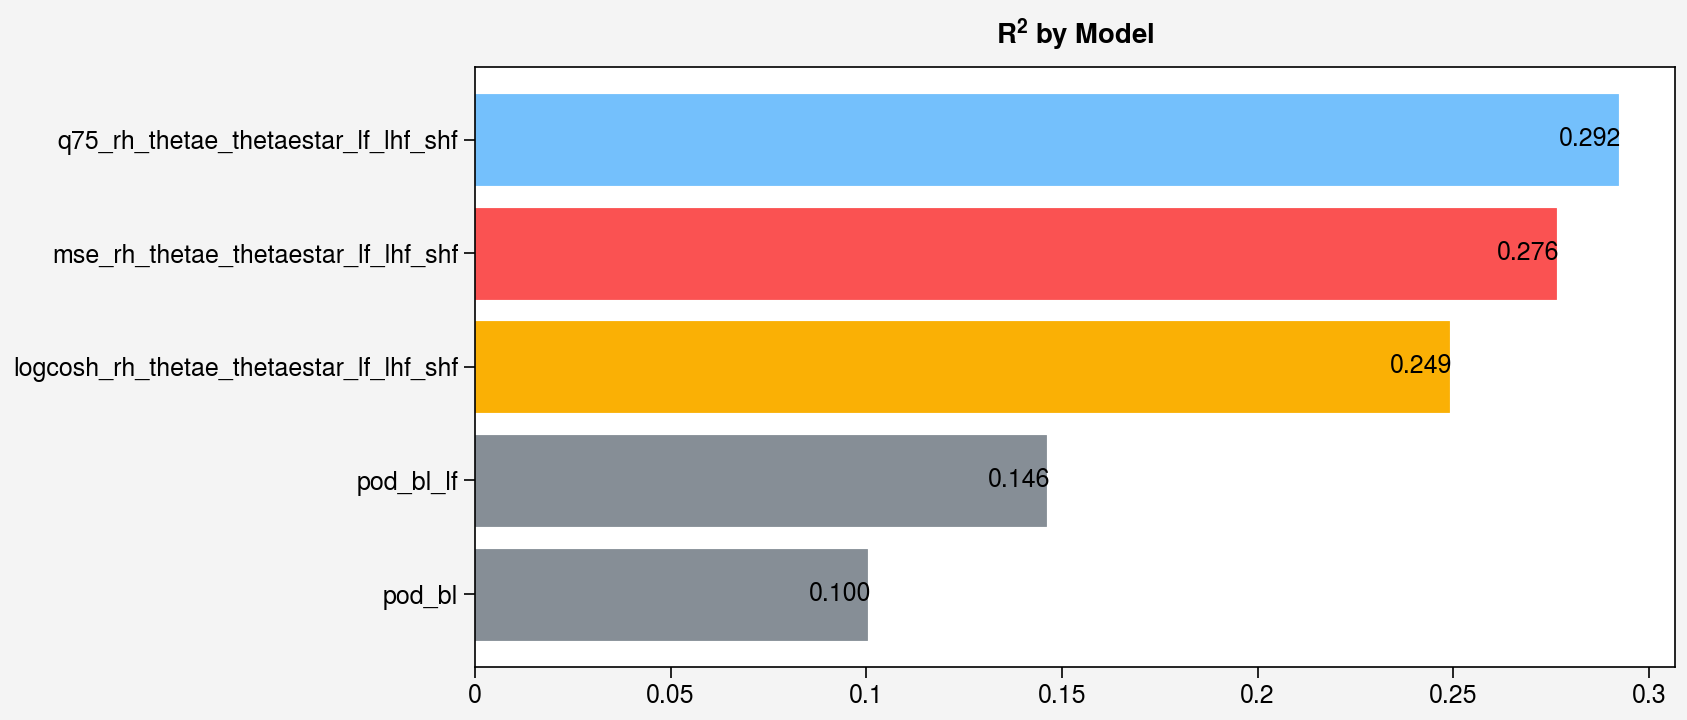

In [111]:
plot_r2_bars(results)

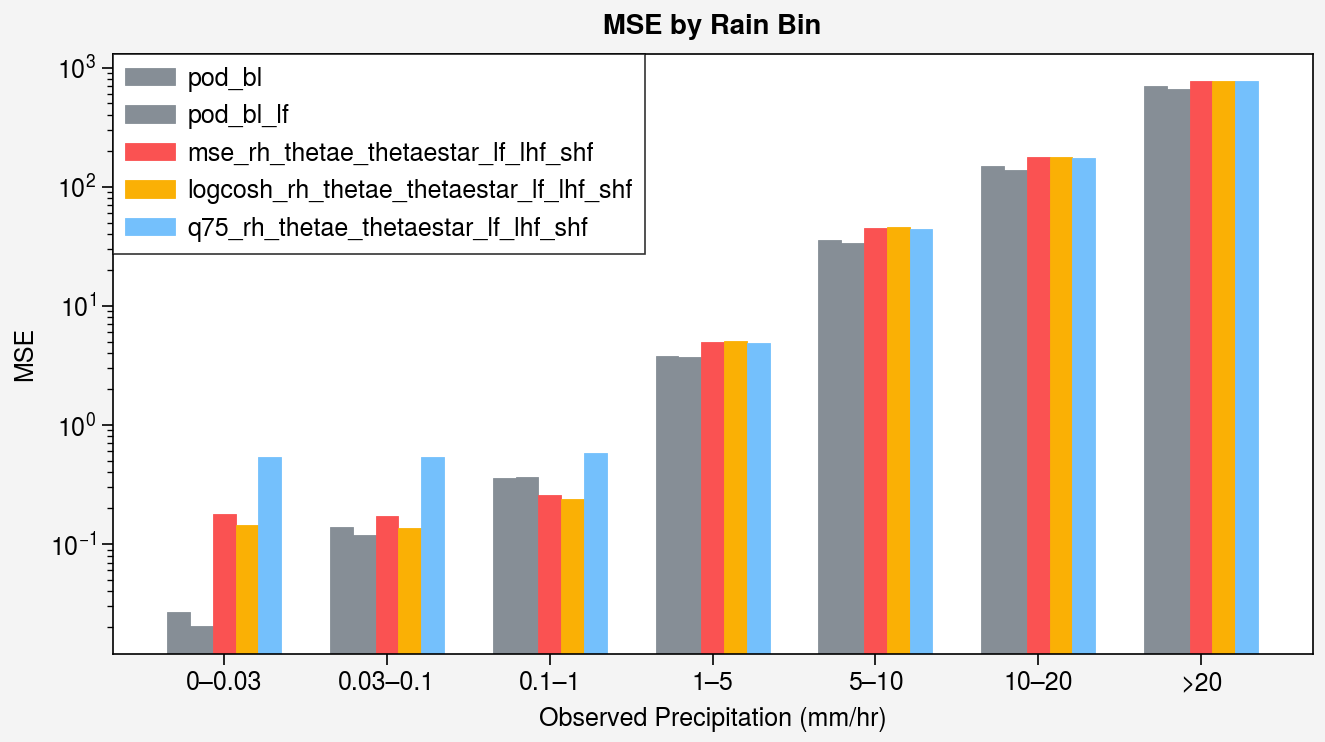

In [112]:
plot_mse_by_bin(results)

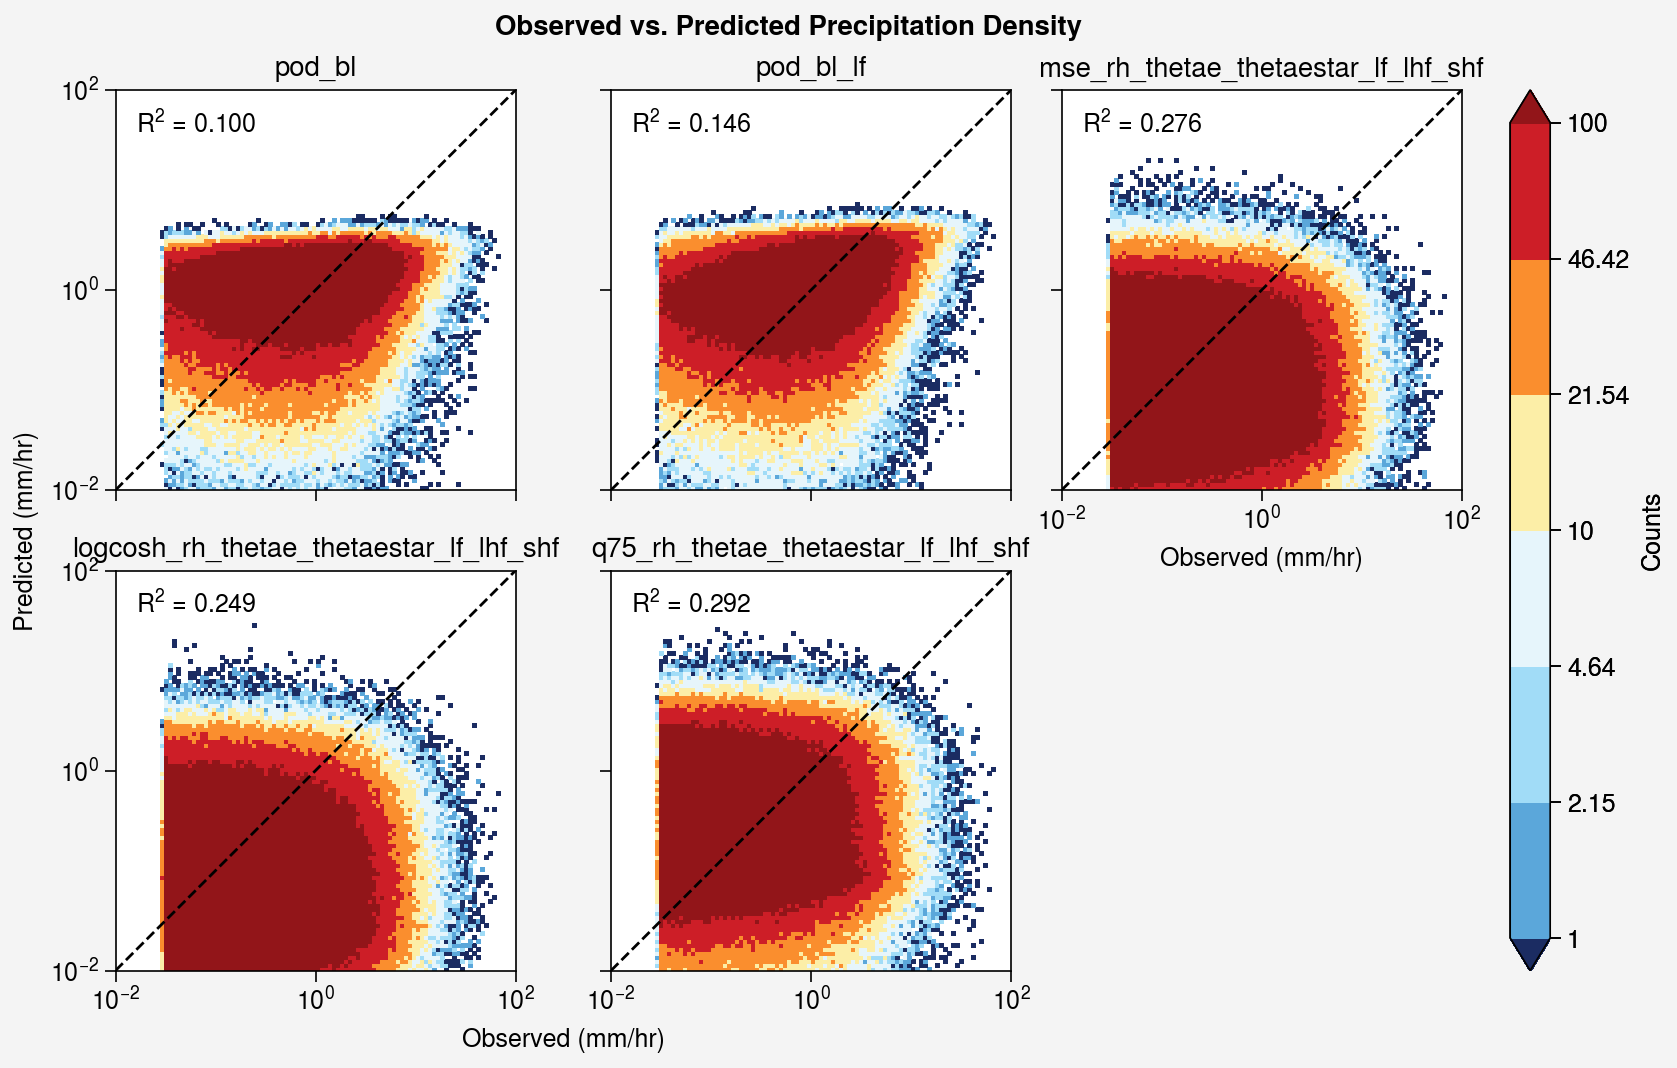

In [118]:
plot_density_panels(results,globalmin=1e-2,globalmax=1e2,nbins=100)

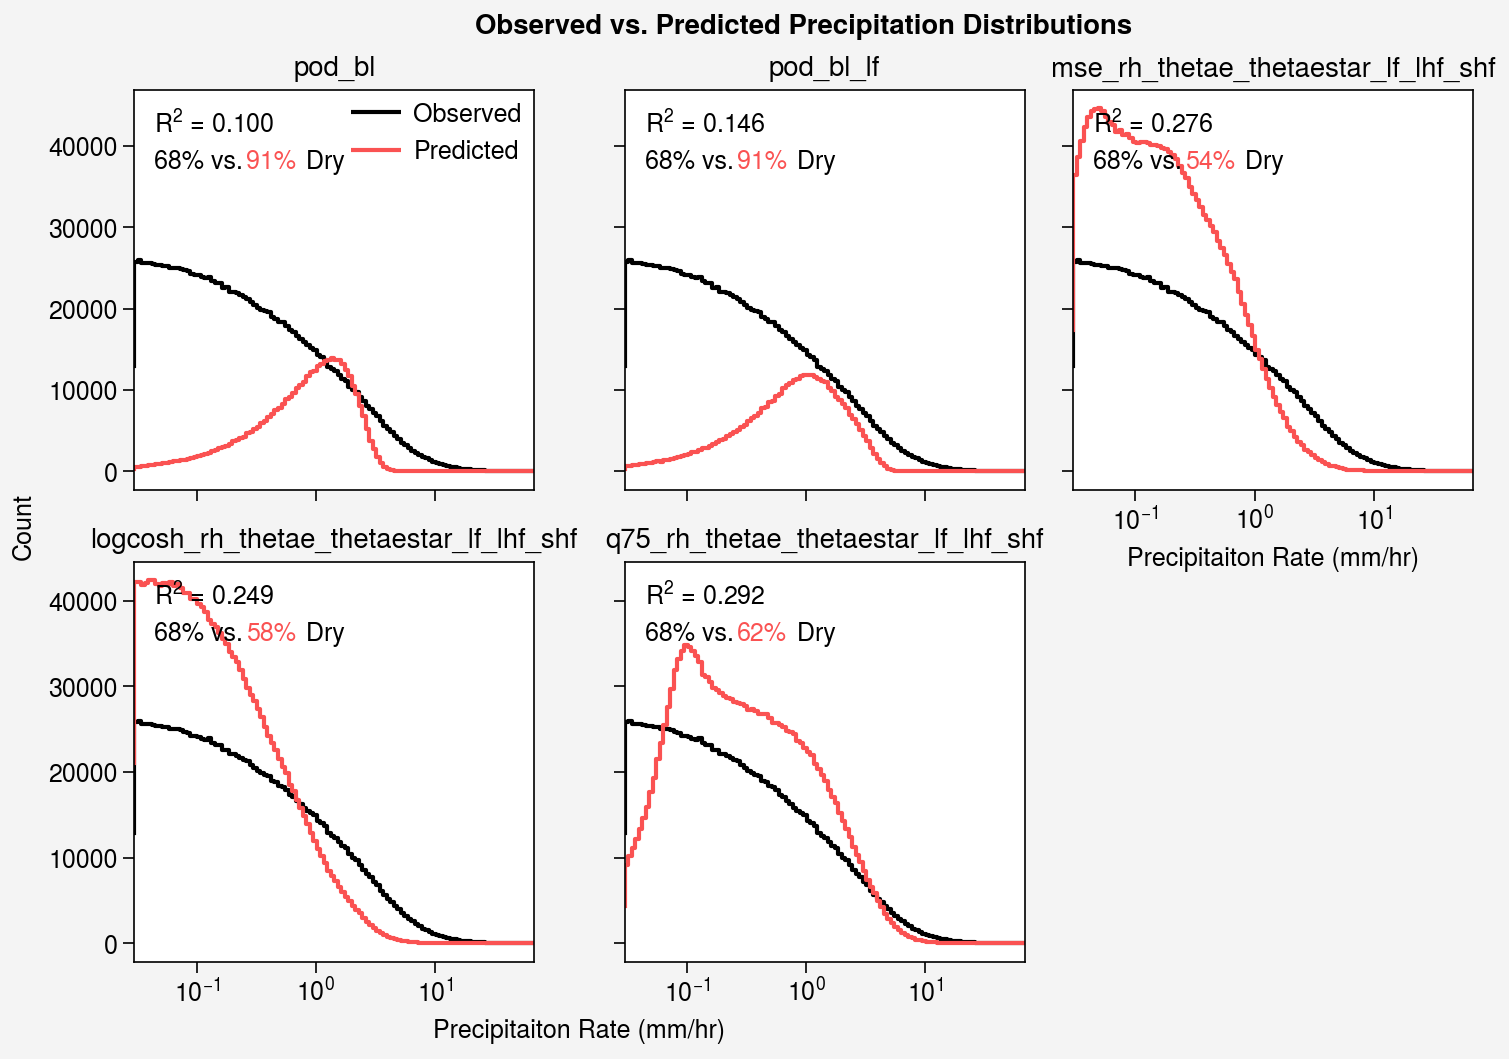

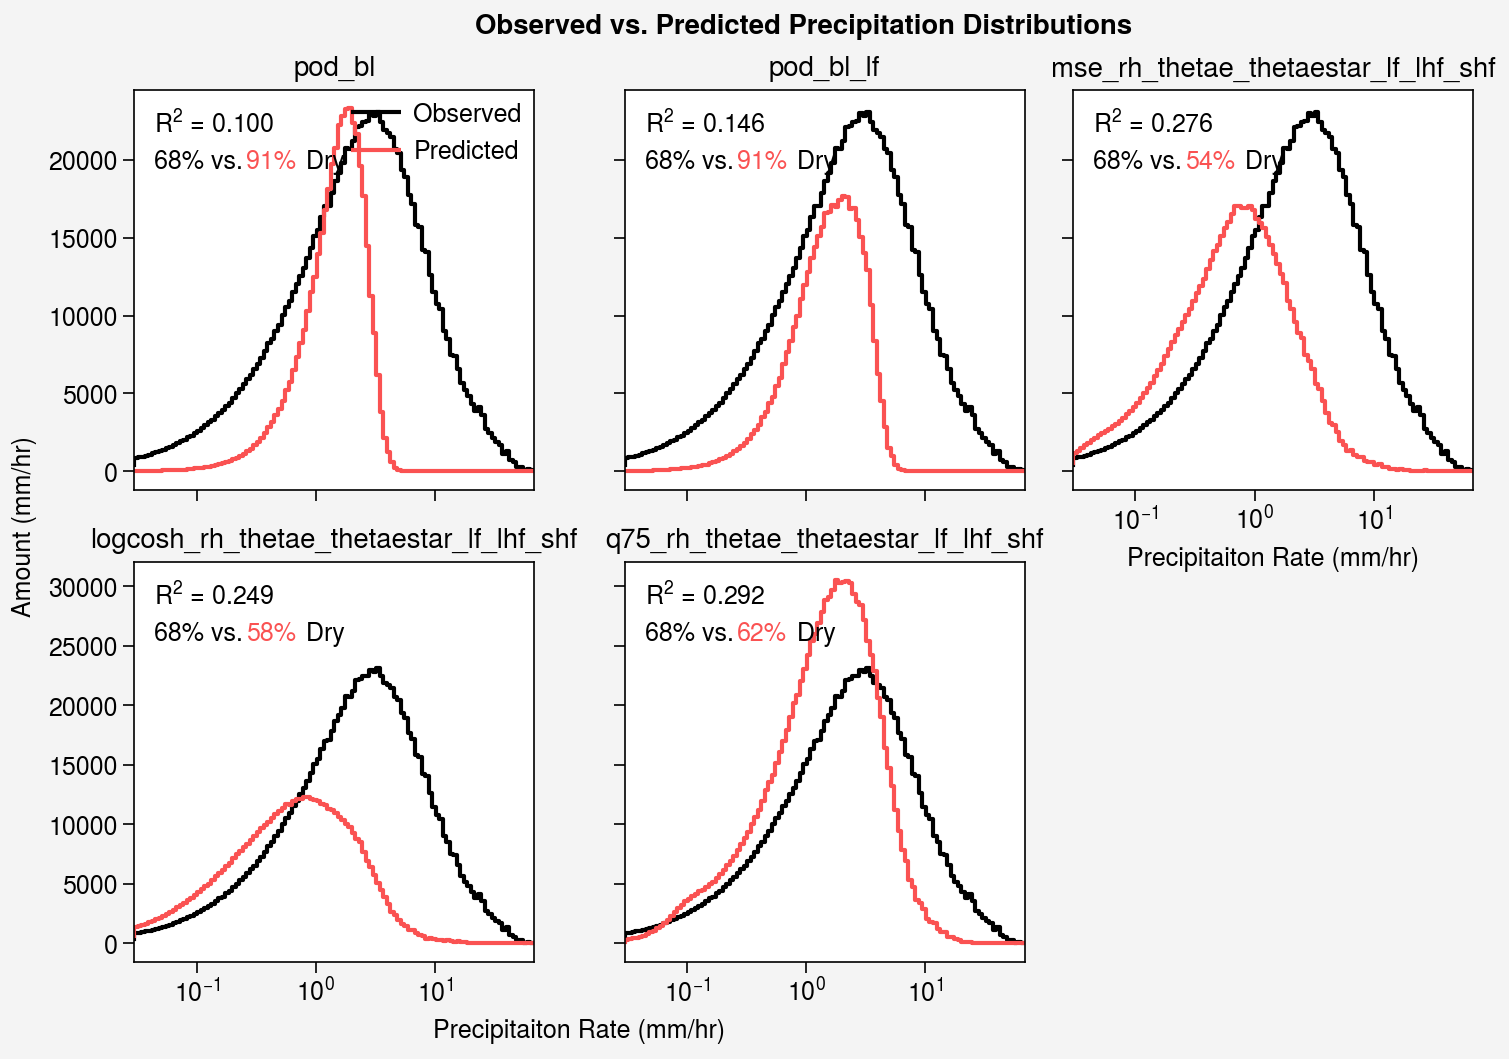

In [116]:
plot_rain_distribution_panels(results,mode='frequency')
plot_rain_distribution_panels(results,mode='amount')

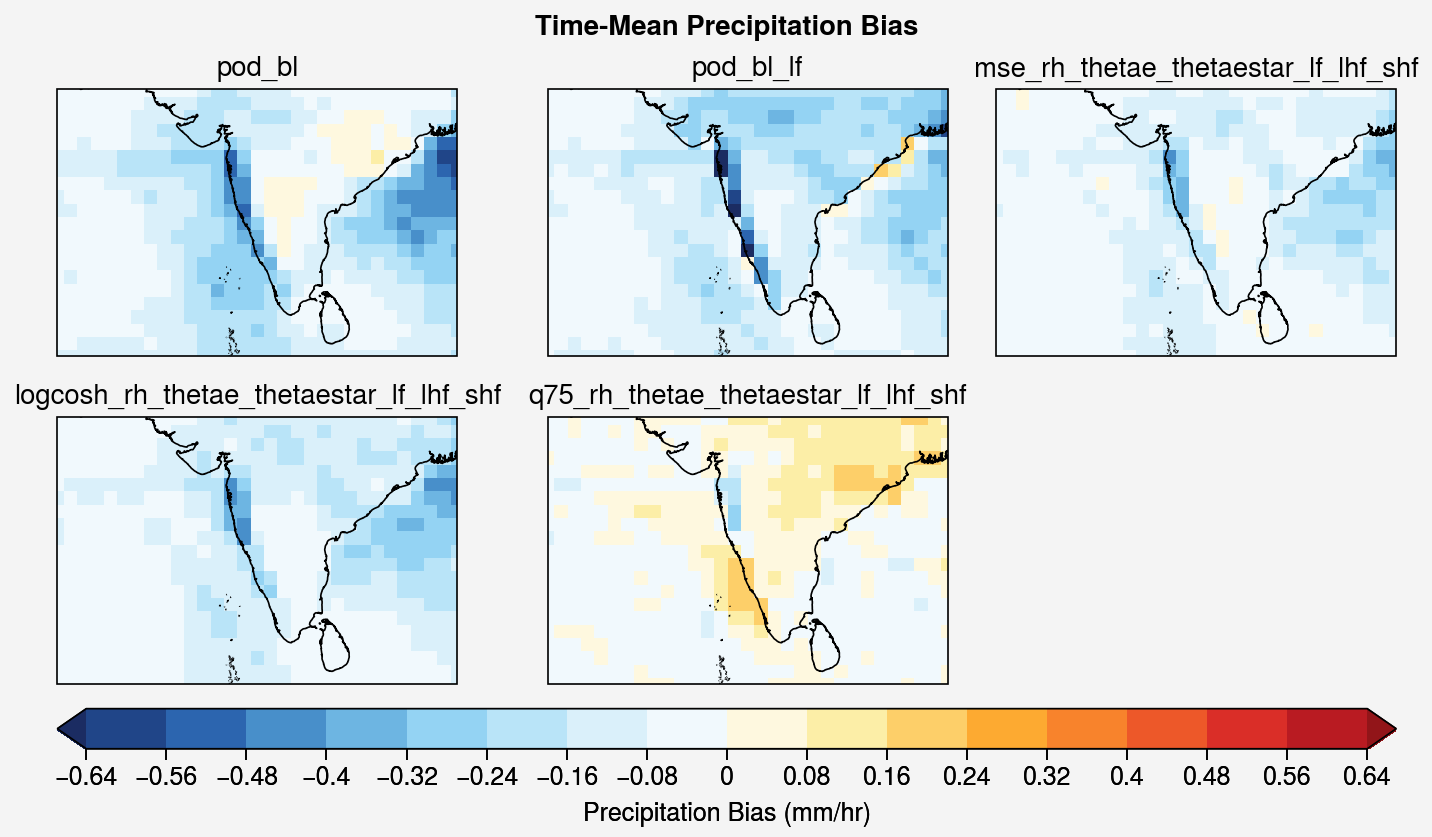

In [119]:
plot_bias_maps(results)

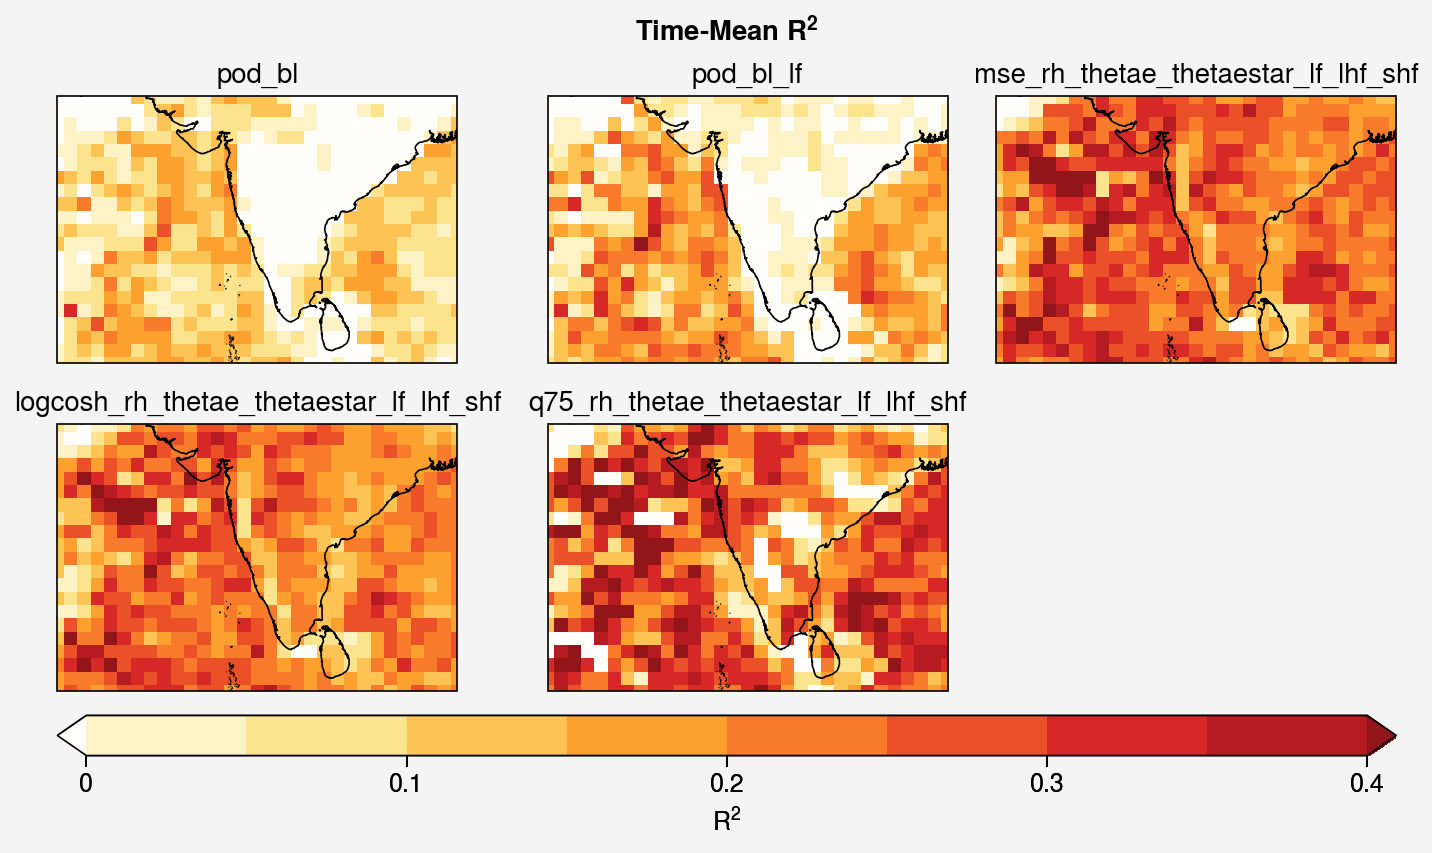

In [120]:
plot_r2_maps(results)

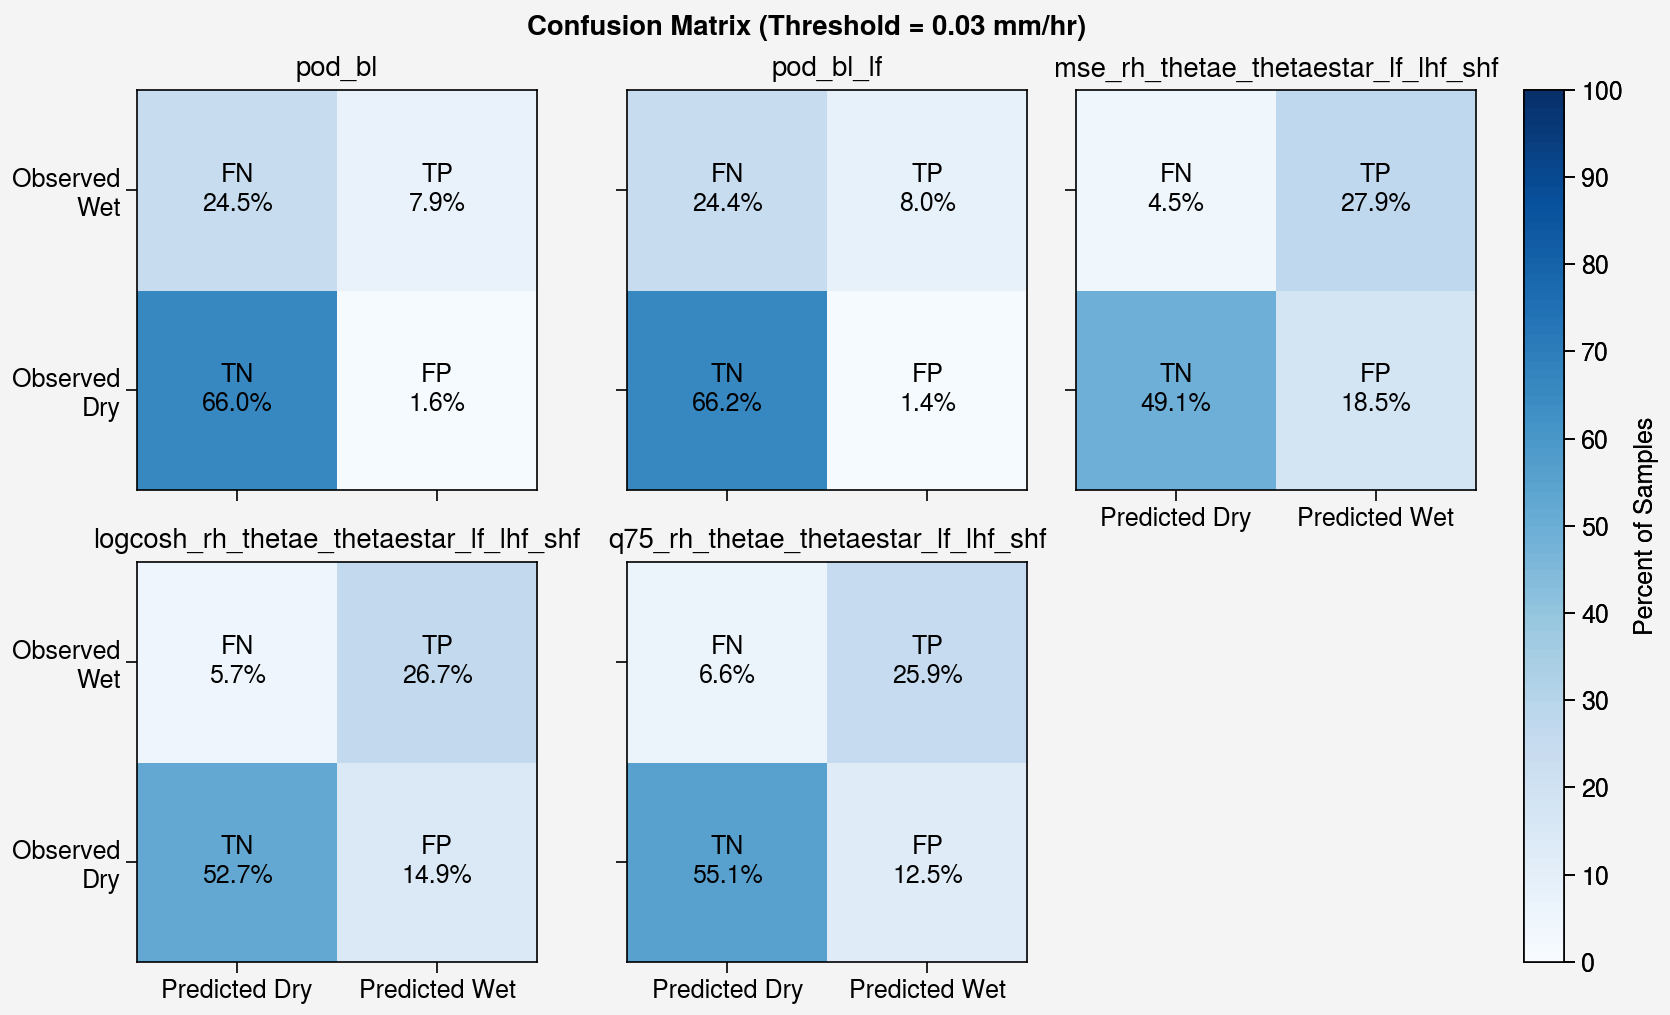

In [121]:
plot_confusion_matrix(results)